In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D,
    Concatenate, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def inception_module(input_tensor, filters=32):
    conv1 = Conv1D(filters, 1, padding='same', activation='relu')(input_tensor)
    conv3 = Conv1D(filters, 3, padding='same', activation='relu')(input_tensor)
    conv5 = Conv1D(filters, 5, padding='same', activation='relu')(input_tensor)
    conv7 = Conv1D(filters, 7, padding='same', activation='relu')(input_tensor)
    output = Concatenate(axis=-1)([conv1, conv3, conv5, conv7])
    return output

In [9]:
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    # Feed Forward
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    return x

In [10]:
inputs = Input(shape=(n_timesteps, n_features))
x = inception_module(inputs, filters=32)
x = MaxPooling1D(pool_size=2)(x)
x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)
x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

inception_transformer_model = Model(inputs, outputs)
inception_transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
inception_transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 32)   │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 32)   │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      1,472 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      2,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 64, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │     66,048 │ max_pooling1d[0]… │
│ (MultiHeadAttentio… │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │      8,320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 128)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 128)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat

 Total params: 240,134 (938.02 KB)

 Trainable params: 240,134 (938.02 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_history = inception_transformer_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.7536 - loss: 0.5930 - val_accuracy: 0.9355 - val_loss: 0.1422
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9454 - loss: 0.1366 - val_accuracy: 0.9389 - val_loss: 0.1207
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.9478 - loss: 0.1261 - val_accuracy: 0.9355 - val_loss: 0.1285
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9444 - loss: 0.1455 - val_accuracy: 0.9491 - val_loss: 0.1339
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 160ms/step - accuracy: 0.9501 - loss: 0.1288 - val_accuracy: 0.9491 - val_loss: 0.1004
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.9539 - loss: 0.1038 - val_accuracy: 0.9440 - val_loss: 0.1136
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9561 - loss: 0.1023 - val_accuracy: 0.9542 - val_loss: 0.1173
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.9537 - loss: 0

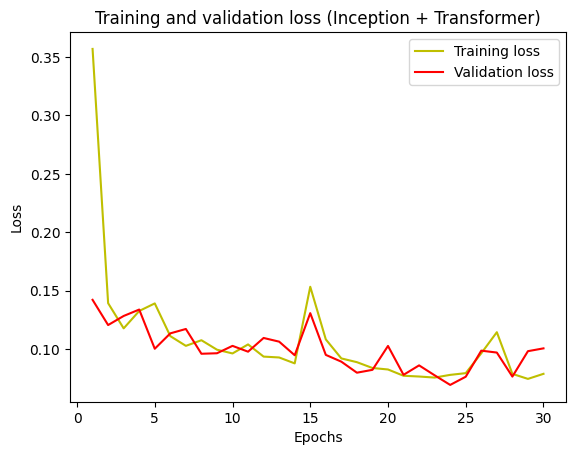

In [12]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (Inception + Transformer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

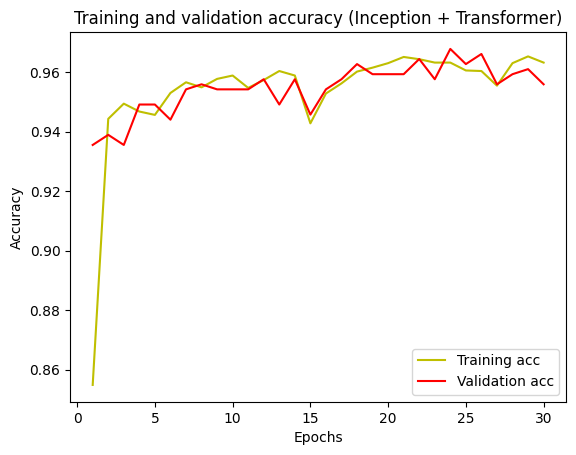

In [13]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (Inception + Transformer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
[[481   3  12   0   0   0]
 [  8 435  28   0   0   0]
 [  1   1 418   0   0   0]
 [  0   3   0 410  73   5]
 [  0   0   0 138 394   0]
 [  0   0   0   0   0 537]]
0.9077027485578555
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       496
           1       0.98      0.92      0.95       471
           2       0.91      1.00      0.95       420
           3       0.75      0.84      0.79       491
           4       0.84      0.74      0.79       532
           5       0.99      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

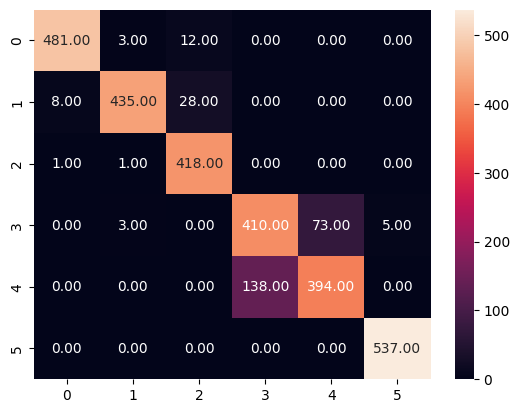

In [14]:
pred = inception_transformer_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')